In [25]:
import pydicom
import pandas as pd
from matplotlib import pyplot
import cv2 
import random
import tensorflow as tf
from tensorflow import keras
import numpy as np

Juntar listas na inicialização

In [26]:
def junta(lista):
    listaJunto=[]
    locs=[]
    nome=''
    for ind, linha in lista.iterrows():
        if nome == linha['patientId']:
            listaJunto[-1][2].append({'x':linha['x'],'y':linha['y'], 'width':linha['width'], 'height':linha['height']})    
            
        else:
            nome = linha['patientId']
            target = linha['Target']
            if target == 1:
                locs.append({'x':linha['x'],'y':linha['y'], 'width':linha['width'], 'height':linha['height']}) 
            
            listaJunto.append([nome, target, locs])
            locs=[]
    
    return listaJunto

Juntar os quadrados localizados 

In [27]:
def juntaRet(listaRet):
    repete = True
    while repete:
        repete = False
        
        for i in range(len(listaRet)):
            for y in range (i+1, len(listaRet)):
                if y < len(listaRet):
                    if (listaRet[i]['col'] <= listaRet[y]['col']  and listaRet[y]['col'] <= listaRet[i]['col2']) or (listaRet[i]['col'] <= listaRet[y]['col2'] and listaRet[y]['col2'] <= listaRet[i]['col2'])  \
                    or (listaRet[y]['col'] <= listaRet[i]['col']  and listaRet[i]['col'] <= listaRet[y]['col2']) or (listaRet[y]['col'] <= listaRet[i]['col2'] and listaRet[i]['col2'] <= listaRet[y]['col2']) :
                        if (listaRet[i]['lin']<= listaRet[y]['lin'] and listaRet[y]['lin'] <= listaRet[i]['lin2']) or (listaRet[i]['lin'] <= listaRet[y]['lin2'] and listaRet[y]['lin2'] <= listaRet[i]['lin2']) \
                        or (listaRet[y]['lin'] <= listaRet[i]['lin']  and listaRet[i]['lin'] <= listaRet[y]['lin2']) or (listaRet[y]['lin'] <= listaRet[i]['lin2'] and listaRet[i]['lin2'] <= listaRet[y]['lin2']):
                            if listaRet[i]['col'] > listaRet[y]['col']:
                                listaRet[i]['col'] = listaRet[y]['col']
                            if listaRet[i]['col2'] < listaRet[y]['col2']:
                                listaRet[i]['col2'] = listaRet[y]['col2']
                            if listaRet[i]['lin'] > listaRet[y]['lin']:
                                listaRet[i]['lin'] = listaRet[y]['lin']
                            if listaRet[i]['lin2'] < listaRet[y]['lin2']:
                                listaRet[i]['lin2'] = listaRet[y]['lin2'] 
                                
                            listaRet[i]['cont'] = listaRet[y]['cont'] +listaRet[i]['cont']
                            listaRet[i]['somaConf'] = listaRet[y]['somaConf'] + listaRet[i]['somaConf']
                        
                            del listaRet[y]
                            repete = True
    
    return listaRet

In [28]:
#alterar para os dados oficiais depois
teste = pd.read_csv('../input/rsna-pneumonia-detection-challenge/stage_1_train_labels.csv')
teste = junta(teste)

img =[]
testeInfo=[]
numFig =10
for i in range(0, numFig):
    num = random.randrange(len(teste))
   # num=i
    DICOM = pydicom.read_file('../input/rsna-pneumonia-detection-challenge/stage_1_train_images/{}.dcm'.format(teste[num][0]))
    img.append(DICOM.pixel_array)
    testeInfo.append(teste[num])

import the classifier

In [29]:
model = keras.models.load_model('../input/fork-of-pulm-o-ml-5/ml5.h5')
#model.load_weights('../input/fork-of-pulm-o-ml-5/ml5_w.h5')
model.load_weights('../input/fork-of-pulm-o-ml-5/ml5_cp.h5')
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 6)       60        
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 62, 62, 6)         0         
_________________________________________________________________
flatten (Flatten)            (None, 23064)             0         
_________________________________________________________________
dense (Dense)                (None, 70)                1614550   
_________________________________________________________________
dense_1 (Dense)              (None, 2)                 142       
Total params: 1,614,752
Trainable params: 1,614,752
Non-trainable params: 0
_________________________________________________________________


In [30]:
kernel=(128,128)
pulo=(64,64)
tamanho=(int((1024/pulo[0])-1),  int((1024/pulo[1])-1) )

resultados=[]

#para cada imagem, percorer:
for im in img:
    imgArray=[]
    for i in range(tamanho[0]):        
        for y in range(tamanho[1]):     
            iJan = pulo[0]*i
            yJan = pulo[1]*y
            imgArray.append(im[iJan:iJan+kernel[0], yJan:yJan+kernel[1]])
        
    imgArray = np.array(imgArray)
    imgArray=imgArray.reshape([-1,kernel[0], kernel[1],1])        
    train = tf.convert_to_tensor(imgArray)
    resultados.append(model.predict(train, steps= 1))

In [31]:
local = []
for i in range(len(resultados)):
    for y in range(len(resultados[i])):
        if(resultados[i][y][1] > 0.4):
            local.append((i,y, resultados[i][y][1]))
len(local)

50

In [32]:
coord = []
for i in range(len(local)):
    im = local[i][0]
    lin = (local[i][1]/(tamanho[1]))*pulo[1]
    col = (local[i][1]%(tamanho[0]))*pulo[0]
    lin2= lin + kernel[1]
    col2= col + kernel[0]
    coord.append({
        'im':int(im),
        'lin':int(lin),
        'lin2':int(lin2),
        'col':int(col),
        'col2':int(col2),
        'conf':local[i][2]
    } )

In [33]:
t= 0
tArayImg2= []
tArayImg =[]
count = 0
tId=[]

for i in range(0,numFig):               
    if coord[count]['im'] == i:
        t = coord[count]['im']
        tImg = img[i].copy()
        tImg2 = img[i].copy()
        rets =[] 
        while t == coord[count]['im']:
            rets.append({'col':coord[count]['col'],
                             'lin':coord[count]['lin'],
                             'col2':coord[count]['col2'],
                             'lin2':coord[count]['lin2'],
                             'cont': 1,
                             'somaConf': coord[count]['conf']
                            })
            tImg = cv2.rectangle(tImg, (coord[count]['col'],coord[count]['lin']),(coord[count]['col2'],coord[count]['lin2']),255,2)
            count =count+1              
            if count >= len(coord):
                count = len(coord)-1
                t=''    
                
        rets = juntaRet(rets)
        for r in rets:            
            tImg2 = cv2.rectangle(tImg2, (r['col'],r['lin']),(r['col2'],r['lin2']),255,5)
            cv2.putText(tImg2,str(r['somaConf']/r['cont']),(r['col'],r['lin2']), 0 ,1,255,3)
        tArayImg.append(tImg)
        tArayImg2.append(tImg2)  
        tId.append(i)    
            

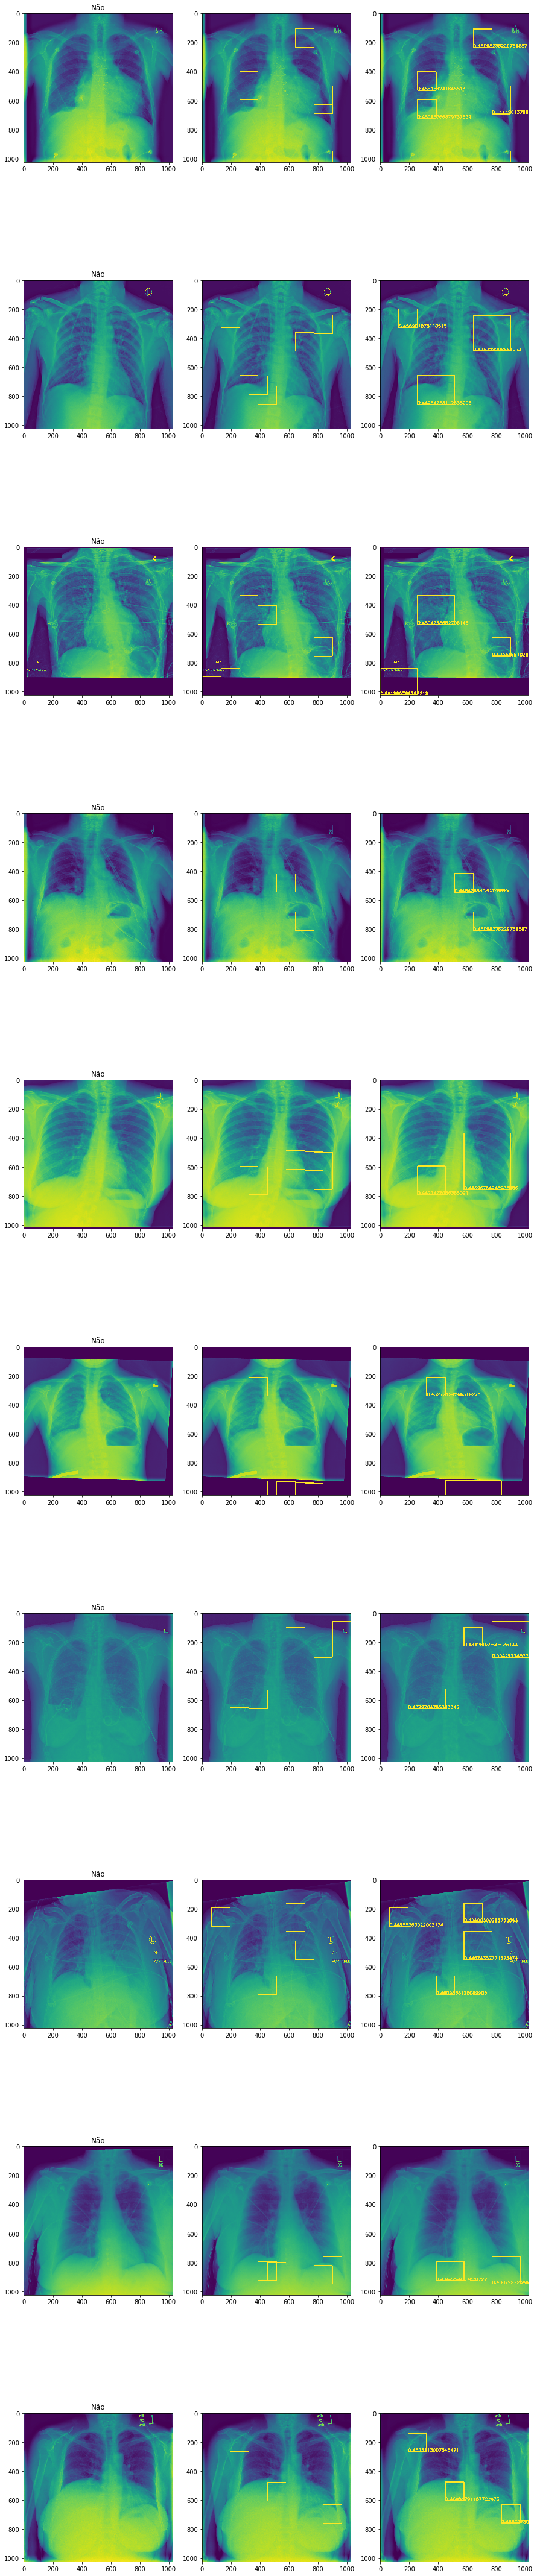

In [34]:
graf, loc= pyplot.subplots(len(tArayImg),3, figsize=(15,80), squeeze=False)
for ti in range(len(tArayImg)):
    i = tId[ti]
    temp = img[i].copy()
    loc[ti][0].set_title('Não')
    if int(testeInfo[i][1]) ==1:
        for pneumo in testeInfo[i][2]:             
            temp = cv2.rectangle(temp, ( int(pneumo['x']),int( pneumo['y']) ), (int(pneumo['x']+ pneumo['width']), int( pneumo['y']+ pneumo['height'] ) ), 255, 5)
            
        loc[ti][0].set_title('Sim')     
    loc[ti][0].imshow(temp)  
    loc[ti][1].imshow(tArayImg[ti])
    loc[ti][2].imshow(tArayImg2[ti])